# 第9回: RNN (Check1)
## 概要
本演習では，ChainerでRNNを実際に実装してみます．扱う時系列データとして，単純な状態遷移に従うシンボル列を用意します．

最後に，RNNの記憶容量の限界について調べます．

## 目標
- Chainerで単純なRNNを実装する
- 単純な状態遷移に従うシンボル列の学習を行う
- RNNの記憶容量の限界を検証する

## 目次
1. MySimpleRNNの実装
2. MySimpleRNNの記憶容量の限界

In [0]:
# install requirements
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


### おまじない
下準備として必要なモジュールを`import`しましょう。そろそろ見慣れてきましたね。

In [0]:
%matplotlib inline
import chainer
from chainer import cuda, Function
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


## (練習課題.1)MySimpleRNNの実装
### 単純な時系列データの学習

ここでは，単純な状態遷移に従う状態遷移をRNNで学習させてみましょう．

例えば，0の次に1が4回現れるというような状態遷移を表す系列は，
```python
trans = [0, 1, 1, 1, 1, 0, 1...]
```
というようになります．

講義で紹介したRNNをしっかりと実装できると，
RNNは0の次に4回1が現れる時系列依存のデータを学習することが出来ます．

### 周期信号の作製
<div class="alert alert-block alert-info">
Note:<br>
このセクションはPythonのコーディングの解説です．読み飛ばしても構いません．
</div>

0と1からなる単純な状態遷移関数を`generator`を使って作成しましょう。
`generator`では、入力パラメータを得て、直ちに一つの値を返す「普通の」関数とは異なり、
「一旦何らかの値を返して、しばらく後に、その時点から処理を再開する」関数を作成することが出来ます。間隔をあけて値を生成することができるため、ジェネレータ関数と呼ばれています。

ジェネレータを使うことによって、値を前もって用意する必要がなくなります。
ここでは、0の次に1がn回続いてまた0が現れる、そしてまた1がn回続くといったオートマトンを表す遷移関数をジェネレータで作成してみることにします。

ジェネレータでは、値を渡すのに`return`ステートメントの代わりに`yield`ステートメントを使用します。`yield`ステートメントを使用した場合、関数は呼び出し元に値を返した後に、終了するのではなく、処理を中断します。そのときに、ステート情報が保持されるため、一時停止したポイントから再度呼び出されたときに処理を再開することが出来ます。

今回の実装では、「0を`yield`したあと、1を指定回数分`yield`する」という繰り返し処理を記述すれば良いことになります。

例えば、こんな風に...

In [0]:
def trans_func(n_one=5):
    while True:
        yield 0
        for i in range(n_one):
            yield 1

ジェネレータ関数は、ジェネレータオブジェクトを生成することが出来ます。

In [0]:
# create a generator
gen = trans_func(3)

ジェネレータオブジェクトは[イテレータプロトコル](https://docs.python.jp/3/c-api/iter.html)をサポートします。
イテレータプロトコルについては、詳しくは述べませんが、繰り返し処理に関する最低限の取り決めと考えて良いでしょう。
イテレータプロトコルをサポートする関数は`__next__`メソッドを持っています。このメソッドを呼ぶと、`yield`で中断された処理を再開することが出来ます。再開後、また`yield`することもあるし、`yield`すべき値が無いと`StopIteration`という例外を投げて終わりを知らせてくれます。
なお、先程作成した`trans_func`ジェネレータ関数には終わりは来ません。永遠と`yield`し続けます。

`__next__`メソッドを何回か呼んでみて「0の次に1がn回続く」という繰り返しが実装できているか確認しましょう。

In [0]:
gen.__next__()

0

さて、ジェネレータの考え方が少しわかったところで、実際に時系列データを作成してみます。

In [0]:
stseq = []
gen = trans_func(3)
for i in range(20):
    stseq.append(gen.__next__())
print(stseq)

[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]


「0の後に1が3回続く」という繰り返しを5回持った時系列データを、配列`stseq`に格納しました。
感の良い方は気付いてしまったかもしれませんが、ジェネレータはすべての値を含んだデータを用意する必要がないところに利用価値がありました。
したがって、このようにジェネレータを使ってデータセットを予め用意するのは本来であればナンセンスなのですが、
こちらのほうが見通しが良いので今回はこのまま解説をしていきたいと思います。

まずはじめに、このデータを学習させてみましょう。

### MySimpleRNNの実装
以上のような時系列データを扱うことができるRNNを実装してみましょう。

In [0]:
class MySimpleRNN(chainer.Chain):
  def __init__(self, n_input, n_hidden, n_output):
    super(MySimpleRNN, self).__init__()
    
    self.n_input = n_input
    self.n_hidden = n_hidden
    self.n_output = n_output
    
    with self.init_scope():
      self.embed = L.EmbedID( "*** YOUR CODE HERE ***")
      self.rec =   "*** YOUR CODE HERE ***"
      self.out =  "*** YOUR CODE HERE ***"
      
    # check input size
    self.h_state = np.zeros((1, self.n_hidden), dtype=np.float32) 
     
  def __call__(self, inpt):
    # forward computation
    x_k =  "*** YOUR CODE HERE ***"
    h_k =  "*** YOUR CODE HERE ***"
    y_k =  "*** YOUR CODE HERE ***"
    
    # update hidden states
    self.h_state =  "*** YOUR CODE HERE ***"
    return y_k
  
  def clearstates(self):
    self.h_state = np.zeros_like(self.h_state, dtype=np.float32) 
  
  def hidden_func(self, x):
    return  "*** YOUR CODE HERE ***"

### 時系列データの学習

さて、いい感じにクラスが作れたので実際に学習させていきましょう。

In [0]:
myrnn = MySimpleRNN(n_input=2, n_hidden=20, n_output=2)
optimizer = chainer.optimizers.Adam()
optimizer.setup(myrnn)

ロスを計算するhelper functionを実装します．

In [0]:
def compute_loss(x_list, model):
  loss = 0
  for curr_x, next_x in zip(x_list, x_list[1:]):
    loss += F.softmax_cross_entropy(model(curr_x), next_x)
  return loss

学習を行います

In [0]:
loss_results = []
inpt_x = np.array(stseq).reshape((-1, 1)).astype('i')
for e in range(300):
    myrnn.cleargrads()  # initialize gradients
    myrnn.clearstates()
    loss = compute_loss(inpt_x, myrnn)  # get loss
    loss.backward()  # compute backpropag
    loss_results += [loss.data]
    optimizer.update()
    print('epoch: {:2d}, loss: {:.3f}'.format(e, float(loss.data)))

epoch:  0, loss: 12.390
epoch:  1, loss: 12.078
epoch:  2, loss: 11.774
epoch:  3, loss: 11.478
epoch:  4, loss: 11.189
epoch:  5, loss: 10.907
epoch:  6, loss: 10.632
epoch:  7, loss: 10.365
epoch:  8, loss: 10.104
epoch:  9, loss: 9.851
epoch: 10, loss: 9.604
epoch: 11, loss: 9.364
epoch: 12, loss: 9.130
epoch: 13, loss: 8.902
epoch: 14, loss: 8.680
epoch: 15, loss: 8.463
epoch: 16, loss: 8.253
epoch: 17, loss: 8.047
epoch: 18, loss: 7.847
epoch: 19, loss: 7.652
epoch: 20, loss: 7.462
epoch: 21, loss: 7.276
epoch: 22, loss: 7.096
epoch: 23, loss: 6.919
epoch: 24, loss: 6.747
epoch: 25, loss: 6.580
epoch: 26, loss: 6.417
epoch: 27, loss: 6.257
epoch: 28, loss: 6.102
epoch: 29, loss: 5.950
epoch: 30, loss: 5.802
epoch: 31, loss: 5.658
epoch: 32, loss: 5.518
epoch: 33, loss: 5.380
epoch: 34, loss: 5.247
epoch: 35, loss: 5.116
epoch: 36, loss: 4.989
epoch: 37, loss: 4.865
epoch: 38, loss: 4.743
epoch: 39, loss: 4.625
epoch: 40, loss: 4.510
epoch: 41, loss: 4.398
epoch: 42, loss: 4.288
ep


epoch: 217, loss: 0.337
epoch: 218, loss: 0.335
epoch: 219, loss: 0.332
epoch: 220, loss: 0.330
epoch: 221, loss: 0.328
epoch: 222, loss: 0.325
epoch: 223, loss: 0.323
epoch: 224, loss: 0.320
epoch: 225, loss: 0.318
epoch: 226, loss: 0.316
epoch: 227, loss: 0.314
epoch: 228, loss: 0.312
epoch: 229, loss: 0.309
epoch: 230, loss: 0.307
epoch: 231, loss: 0.305
epoch: 232, loss: 0.303
epoch: 233, loss: 0.301
epoch: 234, loss: 0.299
epoch: 235, loss: 0.297
epoch: 236, loss: 0.295
epoch: 237, loss: 0.293
epoch: 238, loss: 0.291
epoch: 239, loss: 0.289
epoch: 240, loss: 0.287
epoch: 241, loss: 0.285
epoch: 242, loss: 0.283
epoch: 243, loss: 0.281
epoch: 244, loss: 0.279
epoch: 245, loss: 0.278
epoch: 246, loss: 0.276
epoch: 247, loss: 0.274
epoch: 248, loss: 0.272
epoch: 249, loss: 0.270
epoch: 250, loss: 0.269
epoch: 251, loss: 0.267
epoch: 252, loss: 0.265
epoch: 253, loss: 0.264
epoch: 254, loss: 0.262
epoch: 255, loss: 0.260
epoch: 256, loss: 0.259
epoch: 257, loss: 0.257
epoch: 258, los

結果をプロットしてみます

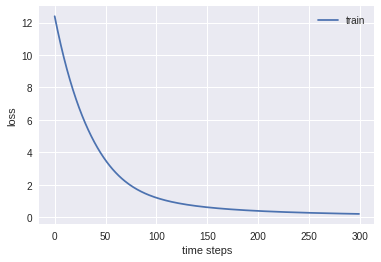

In [0]:
# plot loss results
fig = plt.figure()
x = range(len(loss_results))
ax = fig.add_subplot(111)
ax.set_xlabel('time steps')
ax.set_ylabel('loss')
ax.plot(x, loss_results, label='train')
plt.legend()
plt.show()

### 評価

しっかりとCross Entropyが下がっていることが確認できたところで、predictionをしてみます。

In [0]:
myrnn.clearstates()
predicted = np.array([cuda.to_cpu(myrnn(p).array) for p in inpt_x])[:-1]

予測系列と教師信号からモデルの評価を行います．

In [0]:
def evaluate(teacher, predicted):
    acc = []
    pred = []
    print('Phase: Teacher / Predicted')
    for i, p in enumerate(predicted):
        pred += [np.argmax(p[0])]
        acc += [1 if teacher[i+1] == pred[-1] else 0]
    print('Accuracy: {}%'.format(np.mean(acc) * 100))
    print('Teacher:   {}\nPredicted:  {}'.format(''.join(map(str, teacher)), ''.join(map(str, pred))))
    return acc, pred

In [0]:
acc, pred = evaluate(stseq, predicted)

Phase: Teacher / Predicted
Accuracy: 100.0%
Teacher:   01110111011101110111
Predicted:  1110111011101110111


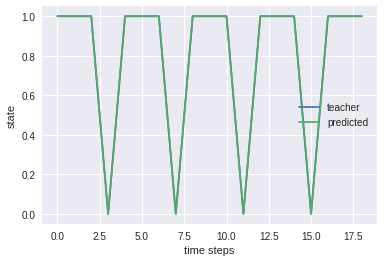

In [0]:
fig1 = plt.figure()
x = range(len(stseq[1:]))
ax = fig1.add_subplot(111)
ax.set_xlabel('time steps')
ax.set_ylabel('state')
ax.plot(x, stseq[1:], label='teacher')
ax.plot(x, pred, label='predicted')
plt.legend()
plt.show()

## (練習課題.2) 記憶容量の限界
ここから実装したRNNに少し意地悪をしていきたいと思います。
`MysimpleRNN`はどこまで記憶することができるでしょうか？

以下の3点を調べてみましょう．
* 長期依存のデータ (「0の後1が50個」を繰り返す時系列データ)
* 複雑な状態遷移を行うデータ (「001001011..」のように一見ランダムに見える時系列データ)
* 隠れ素子の数を減らしてみる

### 時系列データの作製
実装したジェネレータを使って少し複雑な時系列データを作ってみてください。

In [0]:
# create a generator
gen2a = trans_func(10)
gen2b = trans_func(2)

# create a status sequence data
stseq2 = []
for i in range(30):
    stseq2.append(gen2a.__next__())
    stseq2.append(gen2b.__next__())
print(stseq2)

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


### 作成した時系列データの学習

作成したデータを実際に学習させてみましょう。

In [0]:
myrnn = MySimpleRNN(n_input=2, n_hidden=20, n_output=2)
optimizer = chainer.optimizers.Adam()
optimizer.setup(myrnn)

In [0]:
loss_results2 = []
inpt_x2 = np.array(stseq2).reshape((-1, 1)).astype('i')
for e in range(300):
    myrnn.cleargrads()  # initialize gradients
    myrnn.clearstates()
    loss = compute_loss(inpt_x2, myrnn)  # get loss
    loss.backward()  # compute backpropag
    loss_results2 += [loss.data]
    optimizer.update()
    print('epoch: {:2d}, loss: {:.3f}'.format(e, float(loss.data)))

epoch:  0, loss: 62.848
epoch:  1, loss: 61.236
epoch:  2, loss: 58.941
epoch:  3, loss: 56.342
epoch:  4, loss: 53.661
epoch:  5, loss: 51.009
epoch:  6, loss: 48.422
epoch:  7, loss: 45.897
epoch:  8, loss: 43.428
epoch:  9, loss: 41.019
epoch: 10, loss: 38.688
epoch: 11, loss: 36.461
epoch: 12, loss: 34.372
epoch: 13, loss: 32.447
epoch: 14, loss: 30.708
epoch: 15, loss: 29.167
epoch: 16, loss: 27.830
epoch: 17, loss: 26.697
epoch: 18, loss: 25.756
epoch: 19, loss: 24.985
epoch: 20, loss: 24.353
epoch: 21, loss: 23.826
epoch: 22, loss: 23.370
epoch: 23, loss: 22.956
epoch: 24, loss: 22.562
epoch: 25, loss: 22.172
epoch: 26, loss: 21.781
epoch: 27, loss: 21.388
epoch: 28, loss: 21.000
epoch: 29, loss: 20.629
epoch: 30, loss: 20.285
epoch: 31, loss: 19.976
epoch: 32, loss: 19.706
epoch: 33, loss: 19.469
epoch: 34, loss: 19.256
epoch: 35, loss: 19.055
epoch: 36, loss: 18.856
epoch: 37, loss: 18.650
epoch: 38, loss: 18.435
epoch: 39, loss: 18.211
epoch: 40, loss: 17.981
epoch: 41, loss:

epoch: 142, loss: 8.695
epoch: 143, loss: 8.650
epoch: 144, loss: 8.605
epoch: 145, loss: 8.560
epoch: 146, loss: 8.514
epoch: 147, loss: 8.469
epoch: 148, loss: 8.424
epoch: 149, loss: 8.379
epoch: 150, loss: 8.333
epoch: 151, loss: 8.288
epoch: 152, loss: 8.243
epoch: 153, loss: 8.198
epoch: 154, loss: 8.153
epoch: 155, loss: 8.108
epoch: 156, loss: 8.063
epoch: 157, loss: 8.017
epoch: 158, loss: 7.972
epoch: 159, loss: 7.927
epoch: 160, loss: 7.881
epoch: 161, loss: 7.835
epoch: 162, loss: 7.790
epoch: 163, loss: 7.744
epoch: 164, loss: 7.697
epoch: 165, loss: 7.651
epoch: 166, loss: 7.605
epoch: 167, loss: 7.558
epoch: 168, loss: 7.511
epoch: 169, loss: 7.463
epoch: 170, loss: 7.416
epoch: 171, loss: 7.368
epoch: 172, loss: 7.320
epoch: 173, loss: 7.271
epoch: 174, loss: 7.223
epoch: 175, loss: 7.177
epoch: 176, loss: 7.166
epoch: 177, loss: 7.543
epoch: 178, loss: 8.304
epoch: 179, loss: 8.532
epoch: 180, loss: 7.340
epoch: 181, loss: 7.566
epoch: 182, loss: 7.219
epoch: 183, loss

epoch: 284, loss: 11.233
epoch: 285, loss: 11.167
epoch: 286, loss: 11.103
epoch: 287, loss: 11.040
epoch: 288, loss: 10.978
epoch: 289, loss: 10.918
epoch: 290, loss: 10.859
epoch: 291, loss: 10.802
epoch: 292, loss: 10.745
epoch: 293, loss: 10.690
epoch: 294, loss: 10.636
epoch: 295, loss: 10.584
epoch: 296, loss: 10.532
epoch: 297, loss: 10.482
epoch: 298, loss: 10.433
epoch: 299, loss: 10.385


学習過程のlossは以下のようになります．
比較のため，練習1のlossのプロットも合わせて表示してみましょう．

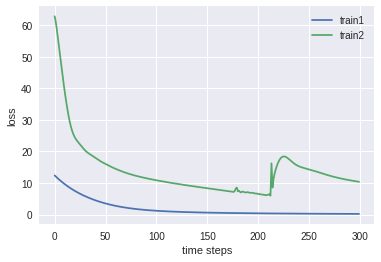

In [0]:
# plot loss results
fig2 = plt.figure()
x = range(len(loss_results))
ax = fig2.add_subplot(111)
ax.set_xlabel('time steps')
ax.set_ylabel('loss')
ax.plot(x, loss_results, label='train1')
ax.plot(x, loss_results2, label='train2')
plt.legend()
plt.show()

### 評価
先ほどと同じように，学習したモデルの評価をしてみます．

In [0]:
myrnn.clearstates()
predicted2 = np.array([cuda.to_cpu(myrnn(p).array) for p in inpt_x2])[:-1]

In [0]:
acc2, pred2 = evaluate(stseq2, predicted2)

Phase: Teacher / Predicted
Accuracy: 96.61016949152543%
Teacher:   001111101111101111101101101111101111101111100111101111101111
Predicted:  01111101111101111101111101111101111101111101111101111101111


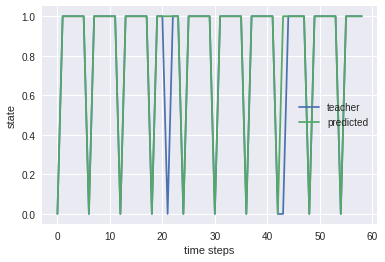

In [0]:
fig2 = plt.figure()
x = range(len(stseq2[1:]))
ax = fig2.add_subplot(111)
ax.set_xlabel('time steps')
ax.set_ylabel('state')
ax.plot(x, stseq2[1:], label='teacher')
ax.plot(x, pred2, label='predicted')
plt.legend()
plt.show()